# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True
5,6,March,Prosecco,144,86,Chile,False
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
8,9,April,Chardonnay,144,57,Chile,False
9,10,April,Prosecco,72,52,California,False


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


##### I want to see a bit more about the data

In [4]:
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
offer_id     32 non-null int64
campaign     32 non-null object
varietal     32 non-null object
min_qty      32 non-null int64
discount     32 non-null int64
origin       32 non-null object
past_peak    32 non-null bool
dtypes: bool(1), int64(3), object(3)
memory usage: 1.6+ KB


In [5]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
customer_name    324 non-null object
offer_id         324 non-null int64
n                324 non-null int64
dtypes: int64(2), object(1)
memory usage: 7.7+ KB


__100 unique customers.  Offer_id is an int (though it's really a categorical variable), so describe doesn't tell me what I want to know.

In [6]:
df_transactions.describe(include='all')

,customer_name,offer_id,n
count,324,324.000000,324.0
unique,100,NaN,NaN
top,Sanders,NaN,NaN
freq,9,NaN,NaN
mean,NaN,17.012346,1.0
std,NaN,9.703332,0.0
min,NaN,1.000000,1.0
25%,NaN,8.000000,1.0
50%,NaN,18.000000,1.0
75%,NaN,26.000000,1.0


##### ints 1-32

In [7]:
sorted(df_transactions.offer_id.unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32]

In [8]:
from collections import Counter

In [9]:
theOfferCounts = Counter(df_transactions.offer_id)

In [10]:
thing = sorted(theOfferCounts.items())

In [11]:
theOffers, theCounts = zip(*thing)

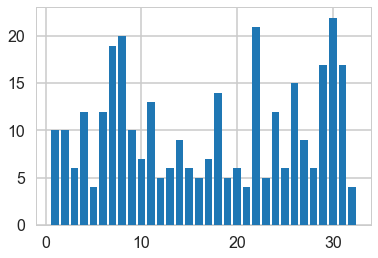

In [12]:
plt.bar(theOffers, theCounts);

##### Okay, 32 different offers, some more popular than others.

## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [13]:
# merge the offers and transactions table
df = pd.merge(df_offers, df_transactions)
# there's only one common column , so pandas uses that the create the joined table. 

In [14]:
df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [15]:
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')

In [16]:
matrix.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
Allen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Bailey,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Baker,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [17]:
matrix = matrix.fillna(0).reset_index(); matrix.index.name='index'

In [18]:
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
index,,,,,,,,,,,,,,,,,,,,,
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

##### Answer: The SS should be small, but not too small.  Consider the case where k=n: here SS = 0, but the k clusters tell us nothing about the data.  One way to restate: increment k until the reduction of slope in SS begins to decline (this is in essence, the elbow method).

##### Answer: build appropriate input for KMeans

In [19]:
x_cols = matrix.iloc[:, 2:].values

In [20]:
x_cols.shape

(100, 31)

##### Answer: The fitted KMeans instance has an attribute called inertia_.  From the documentation: "inertia_ : float, Sum of squared distances of samples to their closest cluster center".  We can use this attribute to get the sum of squares  (http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).

##### The code below runs KMeans with 2 <= k <= 10 and captures the inertia and plots SS vs. k.

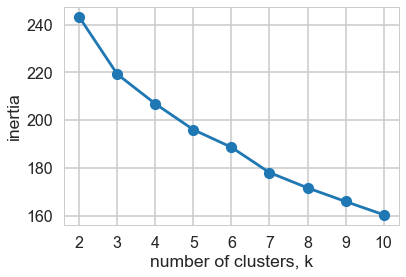

In [21]:
from sklearn.cluster import KMeans

ks = range(2, 11)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=21)
    
    # Fit model to samples
    model.fit(x_cols)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show();

##### Bar plot of number of customers/cluster with k=3, though one could easily choose 4 or 6 for best k.

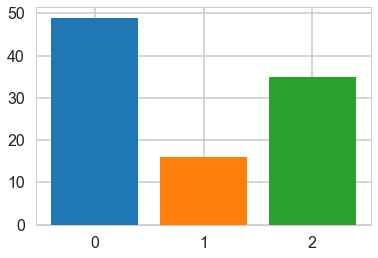

Counter({0: 49, 2: 35, 1: 16})


In [22]:
# make a KMeans instance
k=3
model = KMeans(n_clusters=k, random_state=21)
# fit the kmeans 
model.fit(x_cols)
# get the labels from the fitted instance
labels = model.predict(x_cols)
# count the number of customers in each cluster
counts=Counter(labels)
# get the counts for plotting
for cluster in range(k):
    plt.bar(cluster, counts[cluster])

plt.xticks(range(k))
plt.show();
print(counts)

##### Answer:  An issue with the elbow method is that there is not always a discernable elbow.  In this example, the elbow could be any value between 2 and 10.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [23]:
# Your turn.

##### Answer: reworked the plotting from sklearn documentation to do the desired plots.

For n_clusters = 2 The average silhouette_score is : 0.08446953162122041
For n_clusters = 3 The average silhouette_score is : 0.12435687906779831
For n_clusters = 4 The average silhouette_score is : 0.12544316190019505
For n_clusters = 5 The average silhouette_score is : 0.1296824153059311
For n_clusters = 6 The average silhouette_score is : 0.11676149227340504
For n_clusters = 7 The average silhouette_score is : 0.1371802442819428
For n_clusters = 8 The average silhouette_score is : 0.13348883178625776
For n_clusters = 9 The average silhouette_score is : 0.14008461562416138
For n_clusters = 10 The average silhouette_score is : 0.12404350972260315


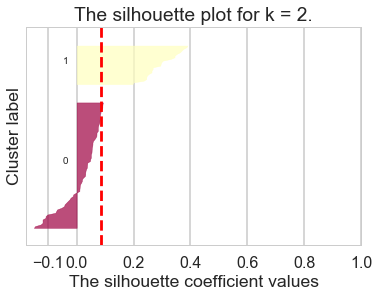

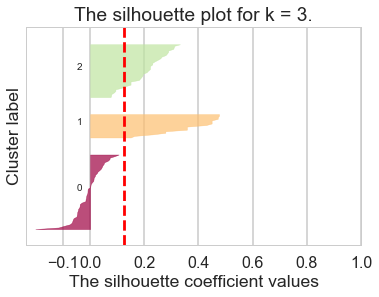

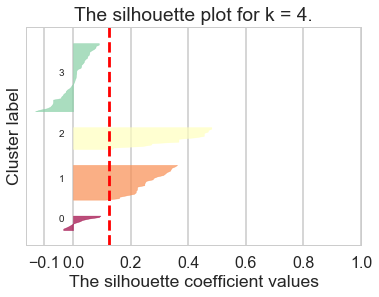

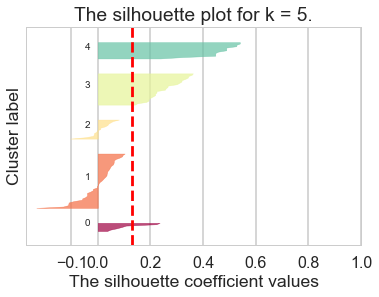

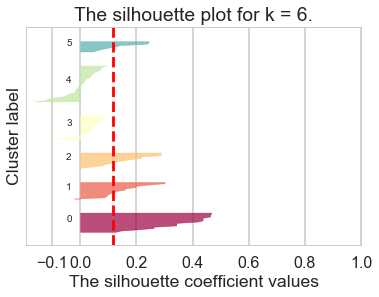

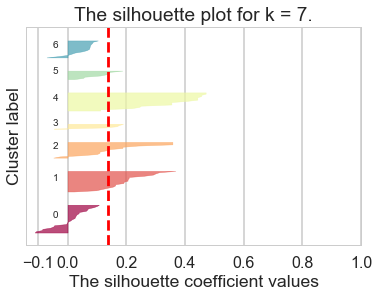

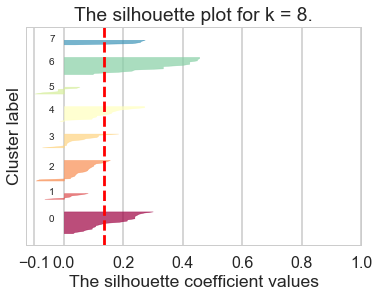

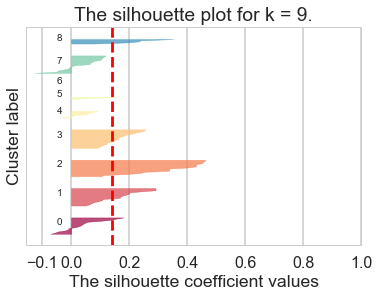

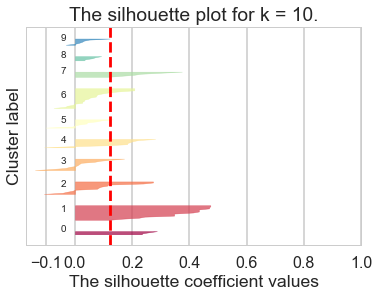

In [24]:
X = x_cols
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np
silhouette_scores = []

for n_clusters in range(2, 11):
    # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1, 1)

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=21)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    ### Grab the average silhouette_score for n_clusters and store it for the next question.
    silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        ###  
        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for k = {}.".format(n_clusters))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

##### Answer: We computed and collected the average silhouette score for each K in the loop above.  We plot the values here.  This plot suggests that the best number of clusters is 9 because that value has the highest average silhouette score in the set {2, 3 ... 10}.  The silhouette plot for k = 9 also shows one of the smallest aggregate negative excursions for those values of k.

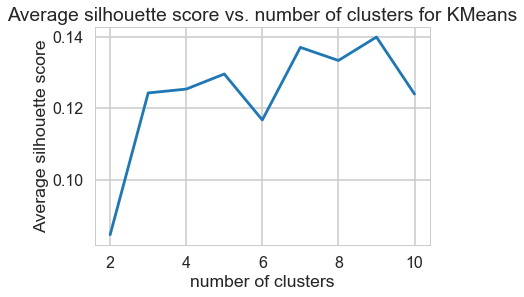

In [25]:
plot_x = list(range(2, 11))
plot_y = silhouette_scores

plt.plot(plot_x, plot_y)
plt.title('Average silhouette score vs. number of clusters for KMeans')
plt.ylabel('Average silhouette score')
plt.xlabel('number of clusters');

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

##### Part 1  - Use scikit-learn's PCA function to reduce the dimensionality of your clustering data to 2 components

In [26]:
#your turn
# get PCA 
from sklearn.decomposition import PCA
# instantiate
pca = PCA(n_components=2)
# fit the PCA to reduce dimension to 2
transformed = pca.fit_transform(x_cols)
transformed.shape

(100, 2)

##### Part 2  - Build a dataframe...

In [27]:
# get the labels
km3_labels = KMeans(n_clusters=3, random_state=21).fit_predict(x_cols)
# build a df for plotting
df_km3 = pd.DataFrame(data = {'customer_name' : matrix.customer_name.values, 
                              'label': km3_labels,
                              'x': transformed[:,0],
                              'y': transformed[:,1]})
df_km3.head()

,customer_name,label,x,y
0,Adams,2,1.014908,0.157764
1,Allen,0,-0.313043,0.019268
2,Anderson,1,-0.451462,1.008114
3,Bailey,2,0.700551,0.006002
4,Baker,0,0.072574,-0.494352


##### Parts 3, 4   Plot...

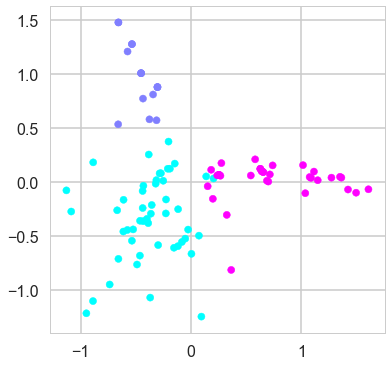

In [28]:
# make a square figure
fig = plt.figure(figsize=(6,6))
# plot color by labels
plt.scatter(df_km3.x, df_km3.y, c=df_km3.label, s=50, cmap=cm.cool);

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

##### Now do it again with k=9

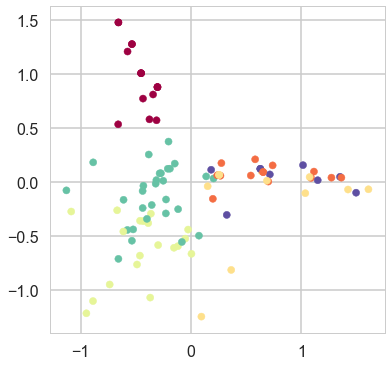

In [29]:
#your turn
# get PCA 
from sklearn.decomposition import PCA
# instantiate
pca = PCA(n_components=2)
# fit the PCA to reduce dimension to 2
transformed = pca.fit_transform(x_cols)
# get the labels
km9_labels = KMeans(n_clusters=6, random_state=21).fit_predict(x_cols)
# build a df for plotting
df_km9 = pd.DataFrame(data = {'customer_name' : matrix.customer_name.values, 
                              'label': km9_labels,
                              'x': transformed[:,0],
                              'y': transformed[:,1]})
plt.figure(figsize=(6, 6))
plt.scatter(df_km9.x, df_km9.y, c=df_km9.label, s=50, cmap=cm.Spectral);

##### Part 5, 6 What do you see...

__k=3 is much more visually satisfying than k=9.  The group separation is much better with almost no overlap and while the groups not tight, they are no worse than k=9.__

#####  Answer: Now look at both the original raw data ... the fitted clusters...

__For group2 (k = 3): This group mostly bought offers in October.  Depending on timing, these could be customers buying in anticipation of Thanksgiving.__

In [30]:
# what is the pink group?  it's group 2
df_km3.groupby('label').count()

,customer_name,x,y
label,,,
0,49,49,49
1,16,16,16
2,35,35,35


In [31]:
df_trans = df_transactions.copy()

In [32]:
# grab a copy of the preprocessed data
df_matrix_clustered = matrix.copy()

In [33]:
# add the cluster labels
df_matrix = df_matrix_clustered.assign(label=df_km3.label)

In [34]:
# and sort
df_matrix.sort_values('label', inplace=True, ascending=False)

In [35]:
# so we can see all the columns
pd.set_option('display.max_columns', 35)

In [36]:
# look at the data for cluster 2
df_matrix[df_matrix.label == 2]

offer_id,customer_name,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,label
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2
47,Long,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
30,Green,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
31,Gutierrez,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
84,Stewart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2
35,Hill,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
37,Hughes,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2
39,James,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
42,Jones,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [37]:
# what were the popular offers for this group
df_matrix.iloc[:, 2:][df_matrix.label == 2].apply(sum, axis=0)

offer_id
2         0.0
3         2.0
4         0.0
5         0.0
6         1.0
7        16.0
8        17.0
9         0.0
10        2.0
11        0.0
12        1.0
13        6.0
14        0.0
15        0.0
16        0.0
17        0.0
18       13.0
19        1.0
20        0.0
21        2.0
22        1.0
23        0.0
24        0.0
25        0.0
26        0.0
27        1.0
28        1.0
29       16.0
30       16.0
31        0.0
32        0.0
label    70.0
dtype: float64

In [38]:
# look at the data for cluster 1
df_matrix[df_matrix.label == 1]

offer_id,customer_name,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,label
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15,Cook,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,Bell,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
76,Rodriguez,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
53,Moore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
11,Campbell,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
79,Russell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
24,Flores,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
41,Johnson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
56,Morris,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


##### Cluster 1 seem to like Cabernet, Prosecco and Chardonnay.

In [39]:
# what were the popular offers for this group
df_matrix.iloc[:, 2:][df_matrix.label == 1].apply(sum, axis=0)

offer_id
2         6.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         0.0
9         0.0
10        1.0
11        0.0
12        1.0
13        0.0
14        0.0
15        0.0
16        1.0
17        7.0
18        0.0
19        0.0
20        0.0
21        0.0
22        0.0
23        1.0
24       12.0
25        0.0
26       12.0
27        1.0
28        0.0
29        0.0
30        0.0
31        0.0
32        0.0
label    16.0
dtype: float64

In [40]:
# look at the data for cluster 0
df_matrix[df_matrix.label == 0]

offer_id,customer_name,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,label
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
71,Reyes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
98,Wright,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
72,Richardson,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
70,Reed,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
97,Wood,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
94,White,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
74,Roberts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
95,Williams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
88,Thompson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [41]:
# what were the popular offers for this group
df_matrix.iloc[:, 2:][df_matrix.label == 0].apply(sum, axis=0)

offer_id
2         4.0
3         4.0
4        12.0
5         4.0
6        11.0
7         3.0
8         3.0
9        10.0
10        4.0
11       13.0
12        3.0
13        0.0
14        9.0
15        6.0
16        4.0
17        0.0
18        1.0
19        4.0
20        6.0
21        2.0
22       20.0
23        4.0
24        0.0
25        6.0
26        3.0
27        7.0
28        5.0
29        1.0
30        6.0
31       17.0
32        4.0
label     0.0
dtype: float64

##### Cluster 0 seem to be seasonal buyers, spring, mid-summer and november-december (but don't care for champagne).

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

##### Plot and find elbow point.

The elbow is at the 4th dimension (number 3 on the graph as they are numbered starting with 0).

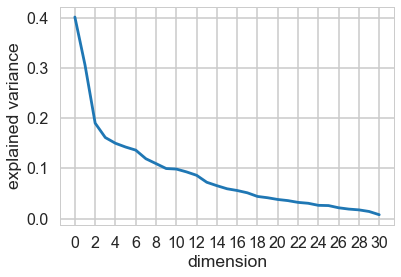

In [42]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)
plt.plot(pca.explained_variance_)
plt.ylabel('explained variance')
plt.xlabel('dimension')
plt.xticks(range(0,32,2));


## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


##### Code below...

##### Answer:

__None of these algorithms seem to find particulary compelling groupings and without spending a substantial amount of time learning how to work with the parameters, it's not clear that they will ever do any better than KMeans on this data set.__

__I don't think any of these algorithms provide a satisfying clustering and that is probably due to the fact that the data is inherently not well clustered.  Wanting to find clusters is natural, but it's entirely possible that clusters do not exist to be found.__

__If there are known to be clusters, if the algorithms fail to find them, there may be issues with the feature selection and tweaking the feature set may help.  This option isn't available to us here.__

##### Affinity propagation

Finds 12 clusters.  Not well separated.

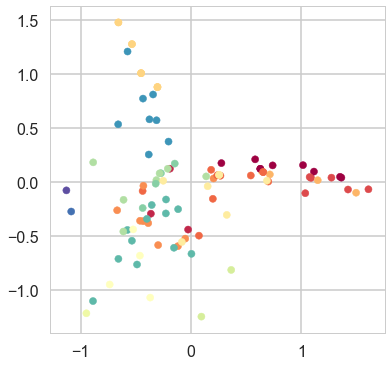

In [43]:
# Your turn
from sklearn.cluster import AffinityPropagation
# grab the template
ap = AffinityPropagation()

# fit to the data and get labels
ap_labels = ap.fit_predict(x_cols)

# take a look at the clusters size and how many
ap_counts = Counter(ap_labels); ap_counts

# now put the clusters together with the 2-d PCA
df_ap = pd.DataFrame(data = {'customer_name' : matrix.customer_name.values, 
                              'label': ap_labels,
                              'x': transformed[:,0],
                              'y': transformed[:,1]})
# and plot
plt.figure(figsize=(6, 6))
plt.scatter(df_ap.x, df_ap.y, c=df_ap.label, s=50, cmap=cm.Spectral);

##### Spectral clustering

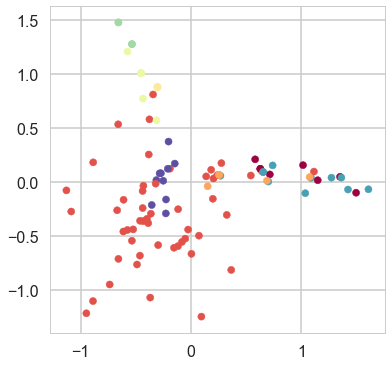

In [44]:
# Your turn
from sklearn.cluster import SpectralClustering
# grab the template, use the default number of clusters (8)
# has a ton of knobs to twiddle, go with defaults to start
sc = SpectralClustering()

# fit to the data and get labels
sc_labels = sc.fit_predict(x_cols)

# take a look at the clusters size and how many
sc_counts = Counter(sc_labels); sc_counts

# now put the clusters together with the 2-d PCA
df_sc = pd.DataFrame(data = {'customer_name' : matrix.customer_name.values, 
                              'label': sc_labels,
                              'x': transformed[:,0],
                              'y': transformed[:,1]})
# and plot
plt.figure(figsize=(6, 6))
plt.scatter(df_sc.x, df_ap.y, c=df_sc.label, s=50, cmap=cm.Spectral);

##### Spectral clustering defaults seem poorly tuned for this data....

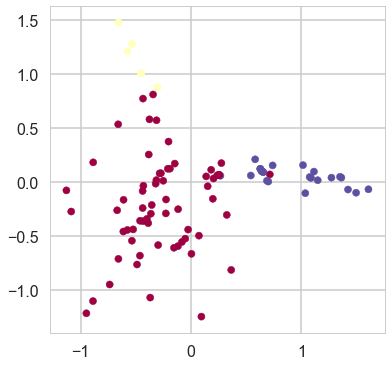

In [45]:
# Your turn
from sklearn.cluster import SpectralClustering
# grab the template, use the k=3
# has a ton of knobs to twiddle, go with defaults to start
sc = SpectralClustering(n_clusters=3)

# fit to the data and get labels
sc_labels = sc.fit_predict(x_cols)

# take a look at the clusters size and how many
sc_counts = Counter(sc_labels); sc_counts

# now put the clusters together with the 2-d PCA
df_sc = pd.DataFrame(data = {'customer_name' : matrix.customer_name.values, 
                              'label': sc_labels,
                              'x': transformed[:,0],
                              'y': transformed[:,1]})
# and plot
plt.figure(figsize=(6, 6))
plt.scatter(df_sc.x, df_ap.y, c=df_sc.label, s=50, cmap=cm.Spectral);

##### k=3 seems like it's on the right track but spectral clustering seems to want to fold everything in quadrants 2, 3 and 4 into one cluster.  Try an intermediate value.

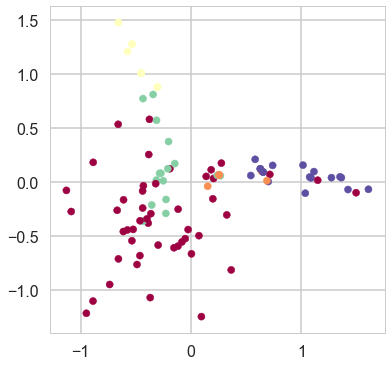

In [46]:
# Your turn
from sklearn.cluster import SpectralClustering
# grab the template, k=5
# has a ton of knobs to twiddle, go with defaults to start
sc = SpectralClustering(n_clusters=5)

# fit to the data and get labels
sc_labels = sc.fit_predict(x_cols)

# take a look at the clusters size and how many
sc_counts = Counter(sc_labels); sc_counts

# now put the clusters together with the 2-d PCA
df_sc = pd.DataFrame(data = {'customer_name' : matrix.customer_name.values, 
                              'label': sc_labels,
                              'x': transformed[:,0],
                              'y': transformed[:,1]})
# and plot
plt.figure(figsize=(6, 6))
plt.scatter(df_sc.x, df_ap.y, c=df_sc.label, s=50, cmap=cm.Spectral);

##### That didn't help - it splits seemingly decent clusters and makes the largest one bigger.

##### Agglomerative Clustering

In [47]:
# Your turn
from sklearn.cluster import AgglomerativeClustering

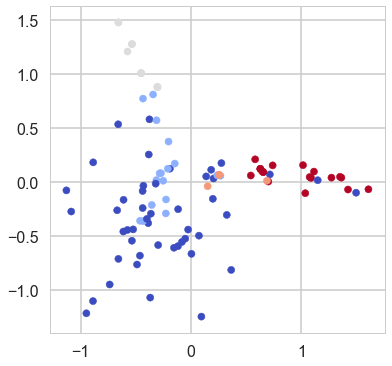

In [48]:
# grab the template
# has a ton of knobs to twiddle, go with defaults to start
ac =  AgglomerativeClustering()

# fit to the data and get labels
sc_labels = sc.fit_predict(x_cols)

# take a look at the clusters size and how many
sc_counts = Counter(sc_labels); sc_counts

# now put the clusters together with the 2-d PCA
df_sc = pd.DataFrame(data = {'customer_name' : matrix.customer_name.values, 
                              'label': sc_labels,
                              'x': transformed[:,0],
                              'y': transformed[:,1]})
# and plot
plt.figure(figsize=(6, 6))
plt.scatter(df_sc.x, df_ap.y, c=df_sc.label, s=50, cmap=cm.coolwarm);

In [49]:
# Your turn
from sklearn.cluster import DBSCAN

In [50]:
# grab the template
# has a ton of knobs to twiddle, I got here with some fiddling to get more than one group...
db =  DBSCAN(eps=1, min_samples=3, metric='manhattan', metric_params=None, algorithm='auto', leaf_size=5, p=None, n_jobs=1)

# fit to the data and get labels
db_labels = db.fit_predict(x_cols)

In [51]:
db_labels

array([ 0,  2,  1,  0, -1, -1,  1,  0, -1,  0, -1,  1,  0, -1, -1,  1, -1,
        1,  0, -1,  0,  0, -1, -1,  1, -1, -1, -1,  2, -1,  0, -1, -1, -1,
       -1,  3, -1,  0, -1,  3,  1,  1,  0, -1, -1, -1,  0, -1, -1, -1, -1,
       -1,  1,  1, -1,  0,  1,  0,  0, -1,  2,  0, -1,  0,  0, -1,  1, -1,
       -1,  2, -1,  2, -1,  0,  2,  0,  1, -1, -1,  1, -1, -1, -1,  1,  0,
        3,  0, -1, -1,  0, -1,  0, -1,  0, -1, -1,  0, -1, -1, -1],
      dtype=int64)

In [52]:
# take a look at the clusters size and how many
db_counts = Counter(db_labels); db_counts

Counter({0: 26, 2: 6, 1: 15, -1: 50, 3: 3})

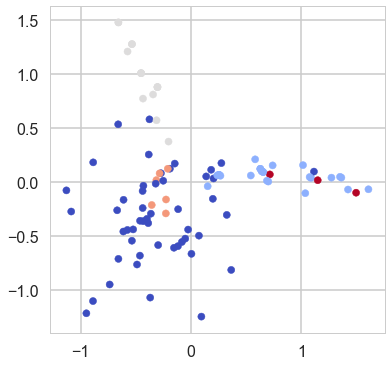

In [53]:
# now put the clusters together with the 2-d PCA
df_db = pd.DataFrame(data = {'customer_name' : matrix.customer_name.values, 
                              'label': db_labels,
                              'x': transformed[:,0],
                              'y': transformed[:,1]})
# and plot
plt.figure(figsize=(6, 6))
plt.scatter(df_db.x, df_db.y, c=df_db.label, s=50, cmap=cm.coolwarm);